In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
r_e = 2.817e-13  # Classical electron radius in cm
m_e = 511  # Electron rest mass energy in keV
alpha = 1 / 137  # Fine-structure constant (dimensionless)
N_a = 6.022e23 # mol^(-1)

# Target parameters
# For a Cu target
rho = 8.96 #g/cm^3
Z = 29 #number of electrons
MM = 63.546 #g/mol

# $\lambda$ Simulation in infinite target

## Cross section calculus

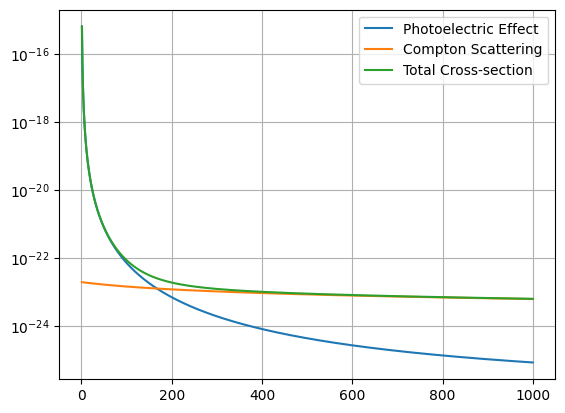

In [ ]:
def cross_section_thomson():
    """
    Calculate the Thomson cross-section, which represents the scattering 
    of electromagnetic waves by free electrons at low photon energies.

    :return: Thomson cross-section in square meters.
    """
    return (8 / 3) * np.pi * r_e ** 2


def cross_section_photoelectric(energy: float, Z: float) -> float:
    """
    Calculate the photoelectric cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Photoelectric cross-section in square meters.
    """
    bond_energy = 0.0047  # Example binding energy in keV
    gamma = (energy + m_e - bond_energy) / m_e 
    c = (3 / 2) * (alpha ** 4) * cross_section_thomson()  # Coefficient based on fine-structure constant

    return c * (
        ((Z * m_e / energy) ** 5) *
        (gamma ** 2 - 1) ** (3/2) *
        (
            (4/3) + (gamma * (gamma - 2) / (gamma + 1)) *
            (
                1 - (1 / (2 * gamma * (gamma ** 2 - 1)**(1/2))) *
                np.log((gamma + (gamma ** 2 - 1)**(1/2)) / (gamma - (gamma ** 2 - 1)**(1/2)))
            )
        )
    )


def cross_section_compton(energy: float, Z: float) -> float:
    """
    Calculate the Compton scattering cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Compton cross-section in square meters.
    """
    epsilon = energy / m_e  # Ratio of photon energy to electron rest mass energy

    # Define calculations for high and low energy regimes
    # These calculations are already vectorized if epsilon is an array
    
    # High energy part
    c_high = 2 * np.pi * r_e ** 2  # Coefficient based on Thomson cross-section
    # Handle potential division by zero if epsilon can be zero or very small.
    # For energy > 100 MeV, epsilon is large.
    term1_high = (1 + epsilon) / epsilon ** 2
    term2_high = (2 * (1 + epsilon) / (1 + 2 * epsilon)) - (np.log(1 + 2 * epsilon) / epsilon)
    term3_high = np.log(1 + 2 * epsilon) / (2 * epsilon)
    term4_high = (1 + 3 * epsilon) / (1 + 2 * epsilon) ** 2
    result_high = c_high * Z * (term1_high * term2_high + term3_high - term4_high)

    # Low energy part
    c_low = cross_section_thomson() 
    poly_term = (
        1 + 2 * epsilon + (6/5) * epsilon ** 2 - (1/2) * epsilon ** 3 +
        (2/7) * epsilon ** 4 - (6/35) * epsilon ** 5 + (8/105) * epsilon ** 6 + (4/105) * epsilon ** 7
    )
    result_low = c_low * Z * (1 / (1 + 2 * epsilon) ** 2) * poly_term
    
    # Use np.where to choose between high and low energy calculations
    return np.where(energy > 100, result_high, result_low)

energies = np.linspace(1, 1000, 1000)  
plt.plot(energies, cross_section_photoelectric(energies, Z), label='Photoelectric Effect')
plt.plot(energies, cross_section_compton(energies, Z), label='Compton Scattering')
plt.plot(energies, cross_section_photoelectric(energies, Z) + cross_section_compton(energies, Z), label='Total Cross-section')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

## $\lambda$ calculus
$$
\lambda = \frac{1}{n_c\sigma_{tot}}
$$

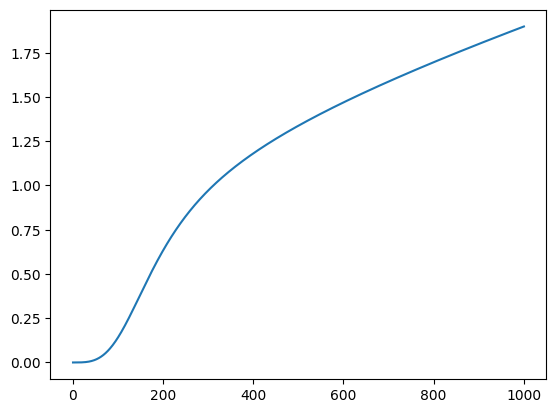

In [ ]:
def attenuation_factor(total_cross_section: float, density_of_scattering_centers: float) -> float:
    """
    Calculate the attenuation factor for a photon traveling through a material.

    :param total_cross_section: Total cross-section for the interaction (in cm²).
    :param scattering_target: Material properties (e.g., density, molar mass).
    :return: Attenuation factor (inverse mean free path).
    """
    return total_cross_section * density_of_scattering_centers # cm^-1

def attenuation_length(energy: float, Z: int) -> float:
    """
    Calculate the attenuation length for a photon traveling through a material.

    :param attenuation_factor: Attenuation factor (inverse mean free path).
    :return: Attenuation length in cm.
    """
    cross_section = cross_section_photoelectric(energy, Z) + cross_section_compton(energy, Z)
    density_of_scattering_centers = rho * N_a / MM  # g/cm^3
    mu = attenuation_factor(cross_section, density_of_scattering_centers)
    return 1 / mu  # cm

plt.plot(energies, attenuation_length(energies, Z))
plt.show()

## NIST data comparison

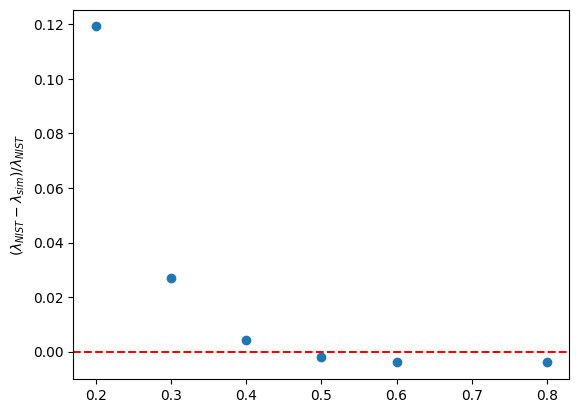

In [ ]:

# NIST data
energies_res = np.array([
    0.2, 0.3, 0.4, 0.5, 0.6,
    0.8])
mu_over_rho = np.array([
    0.1559, 0.1119, 0.09413, 0.08362, 0.07625,
    0.06605
])

# Calcolo mu e lambda
mu = mu_over_rho * rho
lambda_nist = 1 / mu

lambda_simulated = attenuation_length(energies_res * 10 ** 3, Z)

residual = (lambda_nist - lambda_simulated) / lambda_nist
plt.plot(energies_res, residual, 'o')
plt.ylabel(r'$(\lambda_{NIST} - \lambda_{sim}) / \lambda_{NIST}$')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# $\lambda$ Simulation in finite target

lambda_true = 1.3527028008334683 cm
lambda simulated in finite target = [1.4202500000000093, 1.3975000000000102, 1.4079999999999946, 1.4562500000000118, 1.4085000000000116, 1.3947500000000124, 1.347750000000012, 1.2447500000000098, 1.1960000000000108, 1.1482500000000102]


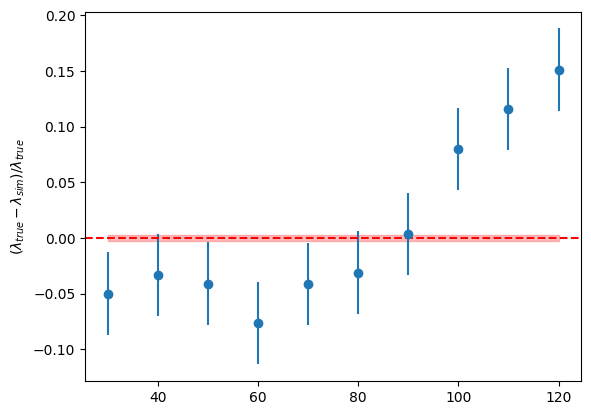

In [ ]:
angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

lambda_simulated_ft = [1.4202500000000093, 1.3975000000000102, 1.4079999999999946, 1.4562500000000118, 1.4085000000000116, 1.3947500000000124, 1.347750000000012, 1.2447500000000098, 1.1960000000000108, 1.1482500000000102]
# precision of 0.05 cm
error = 0.05
lambda_true = attenuation_length(511, Z)
model_error = np.abs(attenuation_length(500, Z) - lambda_nist[3])
print(f"lambda_true = {lambda_true} cm")

residual_ft = (lambda_true - lambda_simulated_ft) / lambda_true
print(f"lambda simulated in finite target = {lambda_simulated_ft}")

plt.errorbar(angles, residual_ft, yerr=error/lambda_true, fmt='o')
plt.ylabel(r'$(\lambda_{true} - \lambda_{sim}) / \lambda_{true}$')
plt.axhline(0, color='red', linestyle='--')
plt.fill_between(angles, -model_error, model_error, color='red', alpha=0.25)
plt.show()

## $\lambda'$ calculus after a Compton scattering

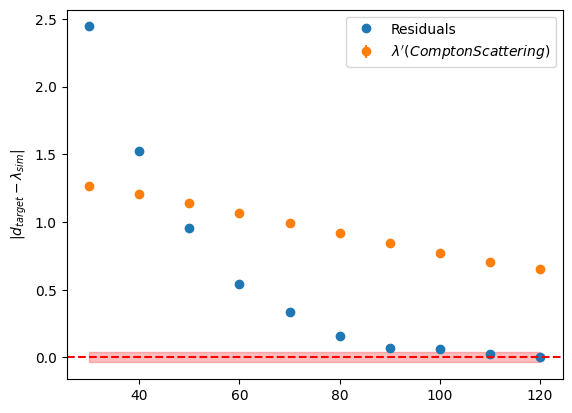

In [ ]:
def target_distance(theta): # for a target with width 1 cm
    return 1 / np.cos((np.pi - np.radians(theta))/2)

def compton_scattering(theta):
    return 511 / (2 - np.cos(np.radians(theta)))

target_distances = target_distance(angles)

residual_target_distance = np.abs(target_distances - lambda_simulated_ft)
lambda_prime = attenuation_length(compton_scattering(angles), Z)

plt.plot(angles, residual_target_distance, 'o', label='Residuals')
plt.errorbar(angles, lambda_prime, yerr=model_error, fmt='o', label=r"$\lambda' (Compton Scattering)$")
plt.ylabel(r'$|d_{target} - \lambda_{sim}|$')
plt.axhline(0, color='red', linestyle='--')
plt.fill_between(angles, -error/lambda_true, error/lambda_true, color='red', alpha=0.25)
plt.legend()
plt.show()

### Observation
When we compute the distance that the photons travel in the target we have to add an error linked to the fact we are using an uncollimated source. 

## $\lambda_{eff}'$ calculus

In conclusion, in general we can assume with a maximum error of 20% that the $\lambda$ from NIST database is the same even if we are studing a finite target. On the other and we have to be very quiet on $\lambda'$, at first approximation we can think to define a $\lambda_{eff}'$ as: 
$$
\lambda_{eff}'= \min(\lambda', |d_{target}-\lambda|)
$$ 

lambda_prime_eff = [1.2641507369164948, 1.2049573900836876, 0.9582015831525039, 0.5437499999999886, 0.3349467956210861, 0.16097382686039996, 0.06646356237308293, 0.06065728933226877, 0.024774588761445226, 0.006450538379241477]


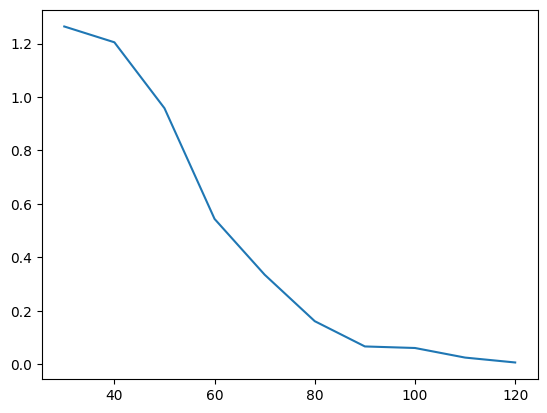

In [ ]:
lambda_prime_eff = [min(l, r) for l,r in zip(lambda_prime, residual_target_distance)]
print(f"lambda_prime_eff = {lambda_prime_eff}")
plt.plot(angles, lambda_prime_eff)
plt.show()